In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
fsa   = 1         # the self-isolation parameter (assumed to be known)

# set the age structure
M=16  ## number of age classes
Ni = pyross.utils.getPopulation(country='UK', M=M)
min_age = 2.5; max_age = 77.5; age = np.linspace(min_age,max_age, M)
N = np.sum(Ni)

CH, CW, CS, CO = pyross.contactMatrix.UK()
def contactMatrix(t):
    return CH + CW + CS + CO

alpha = 0.66*np.exp(-age/50.5) 

Tf = 800
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

S0 = Ni
Ia0 = np.zeros((M))
Ia0[2] += 10
S0[2] -= 10

Is0 = np.zeros((M))
E0 = np.zeros((M))

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau_leaping')

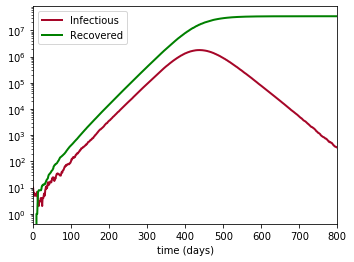

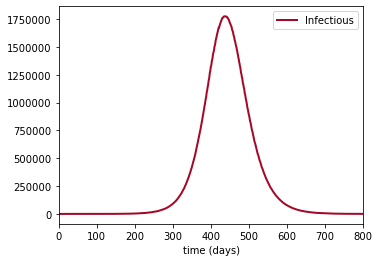

In [4]:
## Plot Results ##

Infectious = np.sum((sto_model.Is(data) + sto_model.Ia(data)), axis=1) 
R = np.sum(sto_model.R(data), axis=1)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.semilogy(data['t'], R,              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2) 
plt.legend()
plt.show()

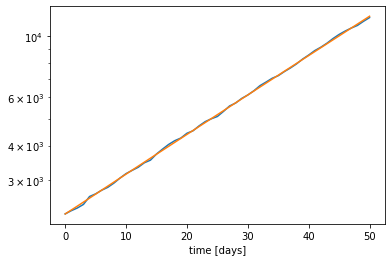

In [5]:
# load the data and rescale to intensive variables 
N_start = 200
Tf_inference = 50 
Nf_inference = Tf_inference + 1

A = 1

x = data['X'].astype('float')
x = x[N_start:N_start+Nf_inference]/A
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni/A, A, steps)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
det_model = estimator.make_det_model(parameters)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.semilogy(np.sum(obs[:, -M:], axis=1))
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1))
plt.xlabel("time [days]")
plt.show()

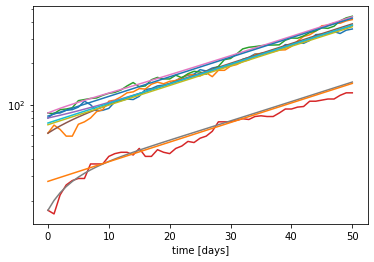

In [7]:
# test the approximation of the initial conditions by v 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 
c = np.linalg.norm(dev, ord=1)
v = estimator.lin_mode_inits(c, contactMatrix)


xm_approx = estimator.integrate(v, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.semilogy(obs[:, -4:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm)[:, -4:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -4:])
plt.xlabel("time [days]")
plt.show()

In [11]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, v, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

6563.814204691461
0.35712289810180664


In [16]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

beta_g = 0.03
beta_std = 0.1
beta_bounds = (eps, 1)

gIa_g = 0.13
gIa_std = 0.02 
gIa_bounds = (eps, 1)

gIs_g = 0.15
gIs_std = 0.05
gIs_bounds = (eps, 1) 

gE_g = 0.11
gE_std = 0.05 
gE_bounds = (eps, 0.2) 

coeff_g = c
coeff_std = coeff_g*5 
coeff_b = (eps, coeff_g*100)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                   coeff_b])
guess = np.array([beta_g, gIa_g, gIs_g, gE_g, coeff_g])
stds = np.array([beta_std, gIa_std, gIs_std, gE_std, coeff_std])
param_keys = ['beta', 'gIa', 'gIs', 'gE']
start_time = time.time()
estimator.set_lyapunov_method('euler')
params = estimator.latent_infer_parameters_lin_mode_init(param_keys, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=True,
                                    enable_global=False, 
                                    cma_population=16,
                                    global_max_iter=100, global_atol=10, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Optimal value (local minimisation):  6306.8381874756
41.36809968948364


In [17]:
# save the parameters 
np.save('SEIR_latent_param_M=16.npy', params)

In [18]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
x0 = x[0]
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(parameters, logp)

print('\nTrue initial conditions: ') 
print((x0*A).astype('int'))
print('R initial = ', (Ni - A*np.sum(x0.reshape((4, M)), axis=0)))

params = np.load('SEIR_latent_param_M=16.npy')
best_estimates = estimator.fill_params_dict(param_keys, params)

coeff = params[-1]
print('\ncoeff for init', coeff)

x0 = estimator.lin_mode_inits(coeff, contactMatrix)
logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

print('\nBest estimates')
print(best_estimates, logp)


print('\nInferred initial conditons: ') 
print((x0*A).astype('int'))
print('R initial = ', (Ni - A*np.sum(x0.reshape((4, M)), axis=0)))

True parameters
{'alpha': array([0.62812229, 0.56891156, 0.51528239, 0.46670865, 0.42271377,
       0.38286612, 0.34677477, 0.31408561, 0.28447793, 0.25766126,
       0.2333725 , 0.21137334, 0.19144797, 0.17340089, 0.15705503,
       0.14225004]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 1} 5511.022407058706

True initial conditions: 
[3950098 4113122 3883102 3680684 4118152 4508221 4681841 4518014 4268986
 4351808 4673289 4461966 3798887 3406375 3328735 2343743     213     314
     369     944     547     549     444     441     444     539     431
     367     163     157     191      66      92      85     109     273
     136     118      89      95      67      99      46      54      16
      20      13       7      60      82     113     297     188     184
     144     201     185     223     185     155      80      62      87
      17]
R initial =  [ 583.  634.  923. 2336. 1246. 1273. 1118. 1182. 1103. 1225.  967.  905.
  339.  3

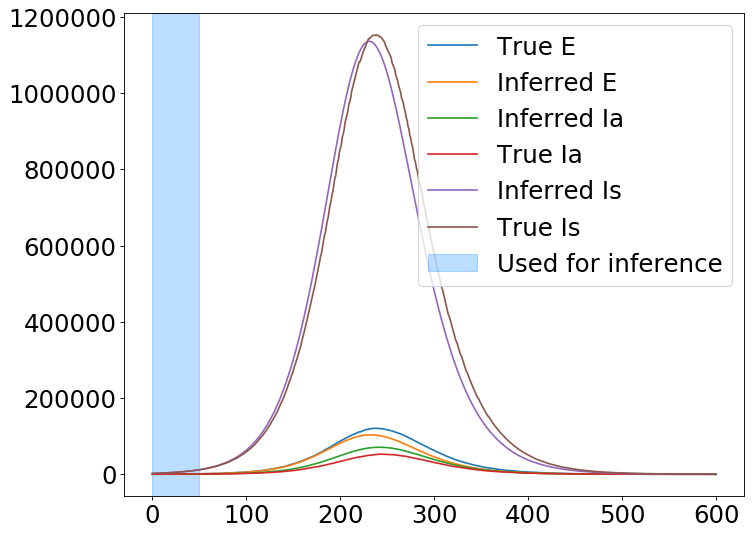

In [22]:
# plot the guessed trajectory and the true trajectory
Tf = 800
Nf = Tf+1

estimator.set_params(best_estimates)
det_model = estimator.make_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf-N_start, Nf-N_start, det_model, contactMatrix)
x = data['X'][N_start:]/A
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,M], label='True E')
plt.plot(x_det[:, M], label='Inferred E')
plt.plot(x_det[:, 2*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show()